In [2]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import sys
import os
from functools import partial
import jax
from jax import numpy as jnp
import numpy as onp
import math
from lean.distributions import CenteredNormal
from flax.core import FrozenDict

In [3]:
import os
os.sys.path.append('/Users/yuanqingwang/Documents/GitHub/lean')

In [4]:
def potential(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        **kwargs,
):
    x = x[..., :, None, :] - x[..., None, :, :]
    x = (x ** 2).sum(-1) + 1e-10
    x = x ** 0.5

    energy = (1 / (2 * tao)) * (
        a * (x - d0)
        + b * (x - d0) ** 2
        + c * (x - d0) ** 4
    )
    return energy

def cos(t):
    return jnp.cos(0.5 * t / math.pi)

def sin(t):
    return jnp.sin(0.5 * t / math.pi)

def coefficient(t, a, b):
    return jax.scipy.special.betainc(a, b, t)

def ess(log_w):
    # normalize
    w = jax.nn.softmax(log_w)
    ess = 1 / (w ** 2).sum()
    return ess

def time_dependent_potential(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        time=0.0,
        schedule_gaussian=None,
        schedule_a=None,
        schedule_b=None,
        schedule_c=None,
        log_sigma=None,

):
    # gaussian_potential = jax.scipy.stats.norm.logpdf(x, scale=scale).sum(-1).sum(-1).mean()

    gaussian_potential = CenteredNormal(log_sigma).log_prob(x).sum(-1).sum(-1).mean()
    gaussian_potential = (1 - schedule_gaussian(time)) * gaussian_potential

    x = x[..., :, None, :] - x[..., None, :, :]
    x = (x ** 2).sum(-1) + 1e-10
    x = x ** 0.5
    x = x.reshape(*x.shape[:-2], -1)
    a_term = a * (x - d0)
    b_term = b * (x - d0) ** 2
    c_term = c * (x - d0) ** 4

    a_term = a_term * schedule_a(time)
    b_term = b_term * schedule_b(time)
    c_term = c_term * schedule_c(time)
    energy = (1 / (2 * tao)) * (a_term + b_term + c_term).sum(-1).mean()
    energy = energy + gaussian_potential
    return energy

@partial(jax.jit, static_argnums=(1, 3))
def compute_log_w(schedules, sampler_params, key, model):
    schedule_gaussian, schedule_a, schedule_b, schedule_c, nn_params = schedules
    key, key_x, key_v = jax.random.split(key, 3)
    x = CenteredNormal(0.0).sample(key_x, (N_PARTICLES, 2, 1))
    h = jnp.zeros((N_PARTICLES, 2, 1))
    h, v = model.apply(nn_params, h, x)

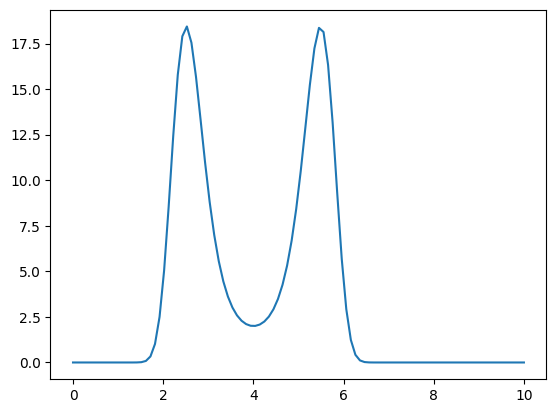

In [5]:
from matplotlib import pyplot as plt
x0 = jnp.linspace(0, 10, 100)
x1 = jnp.zeros_like(x0)
x = jnp.stack([x0, x1], axis=-1)[..., :, None]

plt.plot(
    x0,
    jnp.exp(-potential(x)).sum(-1).sum(-1),
)

In [29]:
from typing import Callable, NamedTuple, Optional
class OverdampedLangevinDynamics(NamedTuple):
    """Overdamped Langevin Dynamics.

    Parameters
    ----------
    potential : Callable
        Energy function.

    integrator : Callable
        Integrator function.

    steps: int
        Number of steps to ta
        
    """
        
    potential: Callable
    step_size: float
    gamma: float = 0.9
    beta: float = 1.0
    mass: float = 1.0
    time: float = 1.0
    
    def step(
            self, 
            position: jnp.ndarray, 
            delta_S: float,
            key: jax.random.PRNGKey,
            time: float = 0.0,
    ):
        """Run the Hamiltonian Monte Carlo algorithm.

        Parameters
        ----------
        position : jnp.ndarray
            Initial position.

        momentum : jnp.ndarray
            Initial momentum.
        """
        
        # compose potential energy
        potential = lambda x: self.potential(x, time=time).sum()

        # compute force
        force = -jax.grad(potential)(position)
        
        epsilon = self.step_size / (self.gamma * self.mass)

        # sample noise
        eta = jax.random.normal(key, shape=position.shape)
        
        position = position \
            + epsilon * force + jnp.sqrt(2 * epsilon / self.beta) * eta
        
        new_force = -jax.grad(potential)(position)
        eta_tilde = jnp.sqrt(0.5 * self.beta * epsilon) * (
            force + new_force
        ) - eta
                
        # compute delta S
        delta_S = delta_S + 0.5 * (
            (eta ** 2).sum(-1).sum(-1)
            - (eta_tilde ** 2).sum(-1).sum(-1)
        ) 
        
        return position, delta_S
    
    def __call__(
            self,
            position: jnp.ndarray,
            key: jax.random.PRNGKey,
    ):
        """Run the Hamiltonian Monte Carlo algorithm.

        Parameters
        ----------
        position : jnp.ndarray
            Initial position.

        momentum : jnp.ndarray
            Initial momentum.
        """        
        # split keys
        steps = int(self.time / self.step_size)
        keys = jax.random.split(key, steps)
        times = jnp.linspace(0, 1, steps)
        
        # initialize state
        state = (position, jnp.zeros(len(position)))

        # run leapfrog integration
        state = jax.lax.fori_loop(
            0, steps, 
            lambda i, state: self.step(*state, time=times[i], key=keys[i]), 
            state,
        )

        # unpack
        position, delta_S = state
        return position, delta_S

In [34]:
position = jax.random.normal(
    jax.random.PRNGKey(0),
    shape=(1000, 2, 1),
)
position = position - position.mean(-2, keepdims=True)

from lean.schedules import SinRBFSchedule
schedule_gaussian = SinRBFSchedule.init(jax.random.PRNGKey(1), 100)
schedule_a = SinRBFSchedule.init(jax.random.PRNGKey(2), 100)
schedule_b = SinRBFSchedule.init(jax.random.PRNGKey(3), 100)
schedule_c = SinRBFSchedule.init(jax.random.PRNGKey(4), 100)
schedules = [schedule_gaussian, schedule_a, schedule_b, schedule_c]

_time_dependent_potential = partial(
    time_dependent_potential,
    schedule_gaussian=schedule_gaussian,
    schedule_a=schedule_a,
    schedule_b=schedule_b,
    schedule_c=schedule_c,
    log_sigma=0.0,
)

# sampler = OverdampedLangevinDynamics(_time_dependent_potential, step_size=1e-2, beta=100, gamma=100.0)
sampler = OverdampedLangevinDynamics(potential, step_size=1e-2, time=50.0)
position, deltaS = sampler(position, key=jax.random.PRNGKey(0))


<Axes: ylabel='Density'>

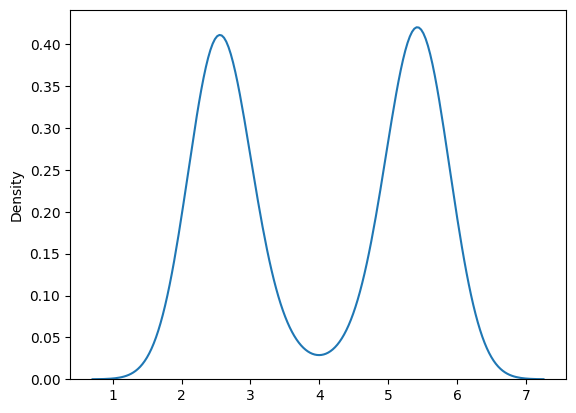

In [35]:
import seaborn as sns
sns.kdeplot(jnp.abs(position[:,0, 0] - position[:,1, 0]))

In [83]:
jnp.abs(position[:,0, 0] - position[:,1, 0]).mean()

Array(2.0440788, dtype=float32)

In [84]:
position

Array([[[ 0.6048788 ],
        [-0.60487866]],

       [[-2.0478845 ],
        [ 2.0478847 ]],

       [[-1.7825423 ],
        [ 1.7825423 ]],

       ...,

       [[-1.41065   ],
        [ 1.4106498 ]],

       [[ 0.47545058],
        [-0.47545046]],

       [[ 2.0175488 ],
        [-2.017549  ]]], dtype=float32)